In [11]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

In [12]:
import matplotlib
%matplotlib notebook

In [19]:
import numpy as np 
import cPickle as pkl
from matplotlib import pyplot as plt
import pandas as pd
from theano_time_corex import *
import linearcorex
from generate_data import *
import vis_utils
import metric_utils
import random
import baselines

# Load Data

### some arguments

In [20]:
nt = 20
train_cnt = 32
val_cnt = 32
test_cnt = 32
data_type='stock_day'
start_date='2000-01-01'
end_date='2018-01-01'

In [21]:
train_data, val_data, test_data = load_stock_data(
        nv=1000, train_cnt=train_cnt, val_cnt=val_cnt, test_cnt=test_cnt,
        data_type=data_type, stride='full',
        start_date=start_date, end_date=end_date)

train_data = train_data[-nt:]
val_data = val_data[-nt:]
test_data = test_data[-nt:]
nt = len(train_data)

print('train shape:', np.array(train_data).shape)
print('val   shape:', np.array(val_data).shape)
print('test  shape:', np.array(test_data).shape)

Loading stock data ...
Stock data is loaded:
	train shape: (43, 32, 1000)
	val   shape: (43, 32, 1000)
	test  shape: (43, 32, 1000)
train shape: (20, 32, 1000)
val   shape: (20, 32, 1000)
test  shape: (20, 32, 1000)


<IPython.core.display.Javascript object>


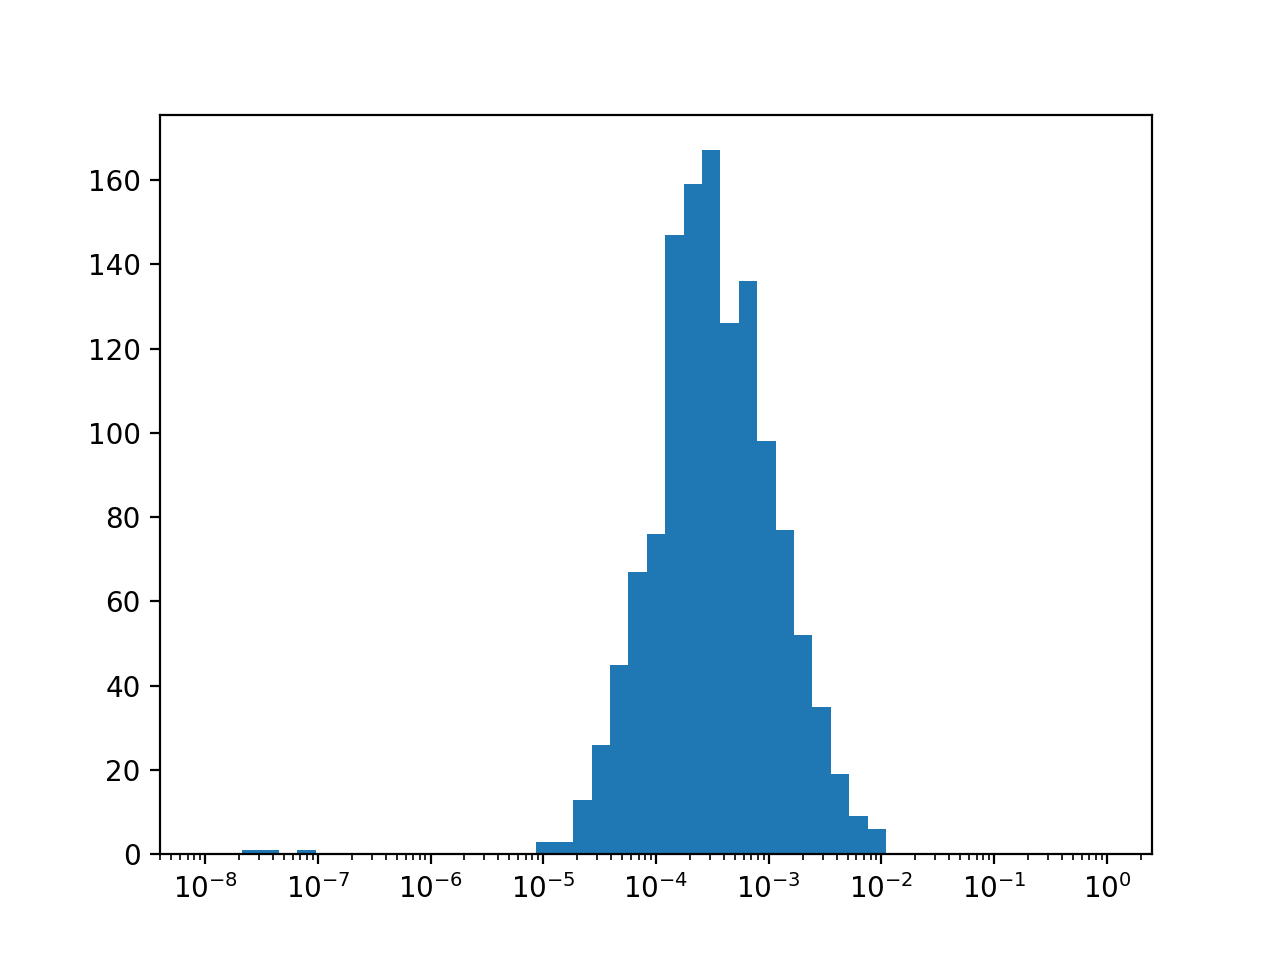

In [23]:
all_vars = []
for t in range(nt):
    all_vars += list(np.var(train_data[t], axis=0))
plt.figure()
plt.hist(all_vars, bins=np.logspace(np.log10(1e-8),np.log10(1.0), 50))
plt.gca().set_xscale("log")

In [22]:
indices = []
for i in range(1000):
    ok = True
    for t in range(nt):
        if np.var(train_data[t][:, i]) > 1e-2:
            ok = False
            break
#     for t in range(nt):
#         if not (1e-8 < np.var(train_data[t][:, i]) < 1e-3):
#             ok = False
#             break
    if ok:
        indices.append(i)

train_data = [x[:, indices] for x in train_data]
val_data = [x[:, indices] for x in val_data]
test_data = [x[:, indices] for x in test_data]
print("Remained {} variables".format(len(indices)))
nv = min(len(indices), 64)

train_data = [x[:, :nv] for x in train_data]
val_data = [x[:, :nv] for x in val_data]
test_data = [x[:, :nv] for x in test_data]

print('train shape:', np.array(train_data).shape)
print('val   shape:', np.array(val_data).shape)
print('test  shape:', np.array(test_data).shape)

Remained 896 variables
train shape: (20, 32, 64)
val   shape: (20, 32, 64)
test  shape: (20, 32, 64)


### scale

In [24]:
# coef = 100.0
coef = 1.0 / np.sqrt( np.var( np.concatenate(train_data, axis=0).reshape((-1, nv)), axis=0 ).mean() )
train_data = [x * coef for x in train_data]
val_data = [x * coef for x in val_data]
test_data = [x * coef for x in test_data]

### add some noise

In [9]:
# for t in range(nt):
#     var = np.var(train_data[t], axis=0)
#     train_data[t] += np.random.multivariate_normal(np.zeros((nv,)), np.diag(var) * 1.0, size=train_data[t].shape[:-1])
#     val_data[t] += np.random.multivariate_normal(np.zeros((nv,)), np.diag(var) * 1.0, size=val_data[t].shape[:-1])
#     test_data[t] += np.random.multivariate_normal(np.zeros((nv,)), np.diag(var) * 1.0, size=test_data[t].shape[:-1])
    
for t in range(nt):
    var = np.var(train_data[t], axis=0)
    train_data[t] += np.random.multivariate_normal(np.zeros((nv,)), np.diag([1e-5]*nv), size=train_data[t].shape[:-1])
    val_data[t] += np.random.multivariate_normal(np.zeros((nv,)), np.diag([1e-5]*nv), size=val_data[t].shape[:-1])
    test_data[t] += np.random.multivariate_normal(np.zeros((nv,)), np.diag([1e-5]*nv), size=test_data[t].shape[:-1])
        
    
print('train shape:', np.array(train_data).shape)
print('val   shape:', np.array(val_data).shape)
print('test  shape:', np.array(test_data).shape)

train shape: (20, 32, 64)
val   shape: (20, 32, 64)
test  shape: (20, 32, 64)


### standardize

In [ ]:
means = [np.mean(x, axis=0) for x in train_data]
stds = [np.sqrt(np.var(x, axis=0)) for x in train_data]

train_data = [(x - m) / s for x,m,s in zip(train_data, means, stds)]
val_data = [(x - m) / s for x,m,s in zip(val_data, means, stds)]
test_data = [(x - m) / s for x,m,s in zip(test_data, means, stds)]

print('train shape:', np.array(train_data).shape)
print('val   shape:', np.array(val_data).shape)
print('test  shape:', np.array(test_data).shape)

In [ ]:
for t in range(nt):
    plt.figure()
    plt.plot(np.var(train_data[t], axis=0))
    plt.show()

# Baselines

In [25]:
nhidden_grid = [8, 16, 32]
tcorex_gamma_grid = [1.25, 1.5, 2.0, 3.0, 4.0]

methods = [
    (baselines.Diagonal(name='Diagonal'), {}),

    (baselines.LedoitWolf(name='Ledoit-Wolf'), {}),

    (baselines.OAS(name='Oracle approximating shrinkage'), {}),

    (baselines.PCA(name='PCA'), {'n_components': nhidden_grid}),

    (baselines.FactorAnalysis(name='Factor Analysis'), {'n_components': nhidden_grid}),
    
    (baselines.LinearCorex(name='Linear CorEx (applied bucket-wise)'), {
        'n_hidden': nhidden_grid,
        'max_iter': 500,
        'anneal': True}),

    (baselines.LinearCorexWholeData(name='Linear CorEx (applied on whole data)'), {
        'n_hidden': nhidden_grid,
        'max_iter': 500,
        'anneal': True}),

    (baselines.GraphLasso(name='Graphical LASSO (sklearn)'), {
        'alpha': [0.003, 0.01, 0.03, 0.1, 0.3, 1.0],
        'mode': 'lars',
        'max_iter': 100}),

    (baselines.TimeVaryingGraphLasso(name='T-GLASSO'), {
        'lamb': [0.01, 0.03, 0.1, 0.3],
        'beta': [0.03, 0.1, 0.3, 1.0],
        'indexOfPenalty': [1],  # TODO: extend grid of this one; NOTE: L2 is slow and not efficient
        'max_iter': 100}),

    (baselines.TimeVaryingGraphLasso(name='T-GLASSO (no reg)'), {
        'lamb': [0.003, 0.01, 0.03, 0.1, 0.3, 1.0],
        'beta': [0.0],
        'indexOfPenalty': [1],
        'max_iter': 100}),

    (baselines.TCorex(tcorex=TCorex, name='T-Corex (W)'), {
        'nv': nv,
        'n_hidden': nhidden_grid,
        'max_iter': 500,
        'anneal': True,
        'reg_params': {
            'l2': [],
            'l1': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        },
        'reg_type': 'W'
    }),

    (baselines.TCorex(tcorex=TCorexWeights, name='T-Corex (W, weighted samples, no reg)'), {
        'nv': nv,
        'n_hidden': nhidden_grid,
        'max_iter': 500,
        'anneal': True,
        'l1': [0.0],
        'l2': 0.0,
        'gamma': tcorex_gamma_grid,
        'reg_type': 'W',
        'init': True
    }),

    (baselines.TCorex(tcorex=TCorexWeights, name='T-Corex (W, weighted samples)'), {
        'nv': nv,
        'n_hidden': nhidden_grid,
        'max_iter': 500,
        'anneal': True,
        'reg_params': {
            # 'l1': [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0],
            'l1': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
            'l2': [],
        },
        'gamma': tcorex_gamma_grid,
        'reg_type': 'W',
        'init': True
    })
]

## Ledoit-Wolf


--------------------------------------------------------------------------------
Selecting the best parameter values for Ledoit-Wolf ...
done 0 / 1 | running with 
Training Ledoit-Wolf ...
	Elapsed time 0.0s
	current score: 75.6291670657

Finished with best validation score: 75.6291670657
Evaluating Ledoit-Wolf ...
	Score: 75.1585


<IPython.core.display.Javascript object>


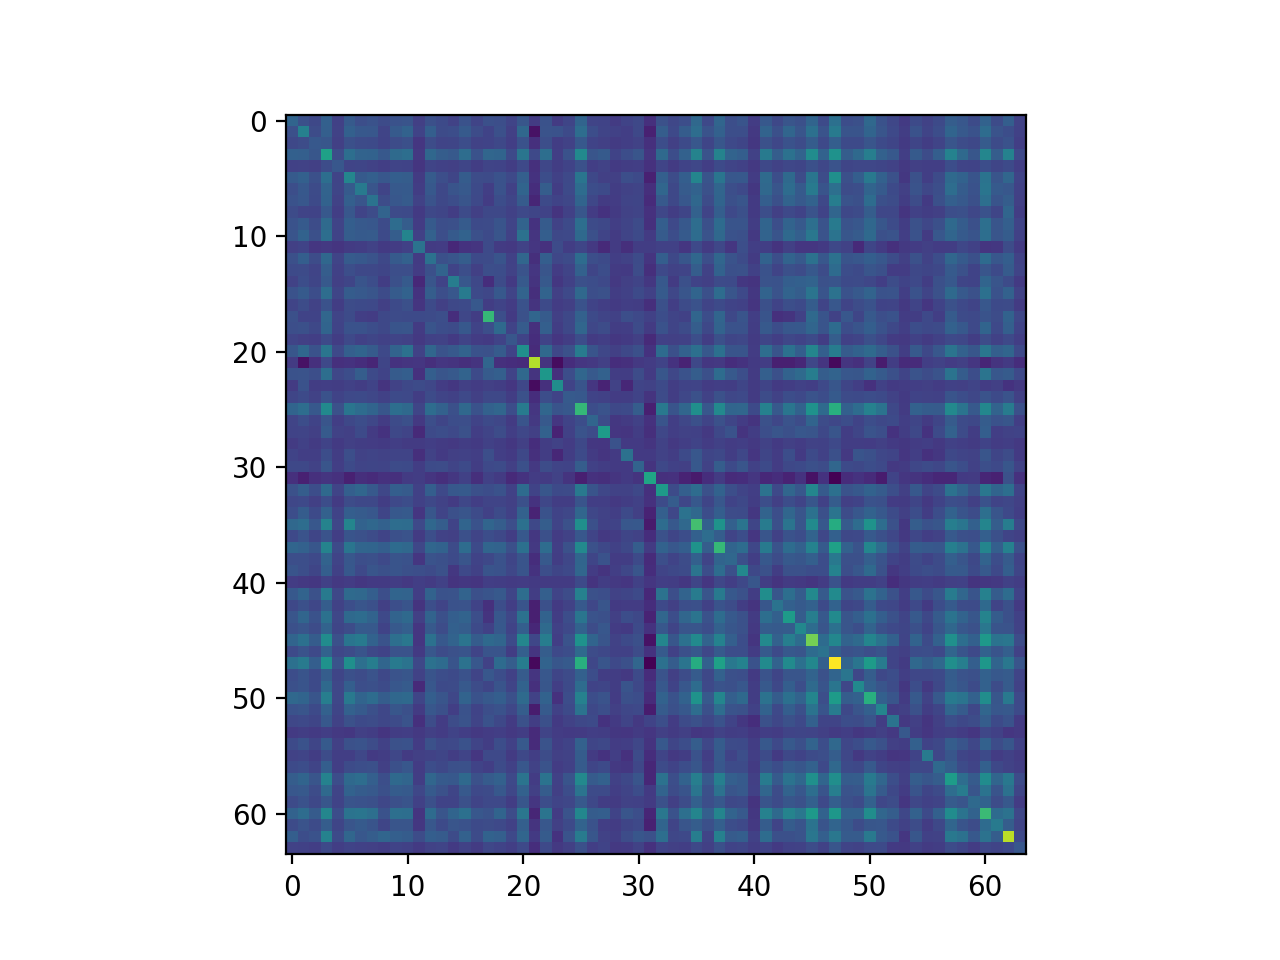

In [26]:
lw = methods[1]
lw_best_score, lw_best_params, lw_covs, _ = lw[0].select(train_data, val_data, lw[1])
lw[0].evaluate(test_data)

plt.figure()
plt.imshow(lw_covs[0])
plt.show()

## T-GLASSO


--------------------------------------------------------------------------------
Selecting the best parameter values for T-GLASSO (no reg) ...
done 0 / 1 | running with lamb: 1.0	beta: 0.0	
Training T-GLASSO (no reg) ...
Use l-1 penalty function
20
lambda = 1.0, beta = 0.0
	Elapsed time 38.8s
	current score: 73.9749077861

Finished with best validation score: 73.9749077861
Evaluating T-GLASSO (no reg) ...
	Score: 74.7288


<IPython.core.display.Javascript object>


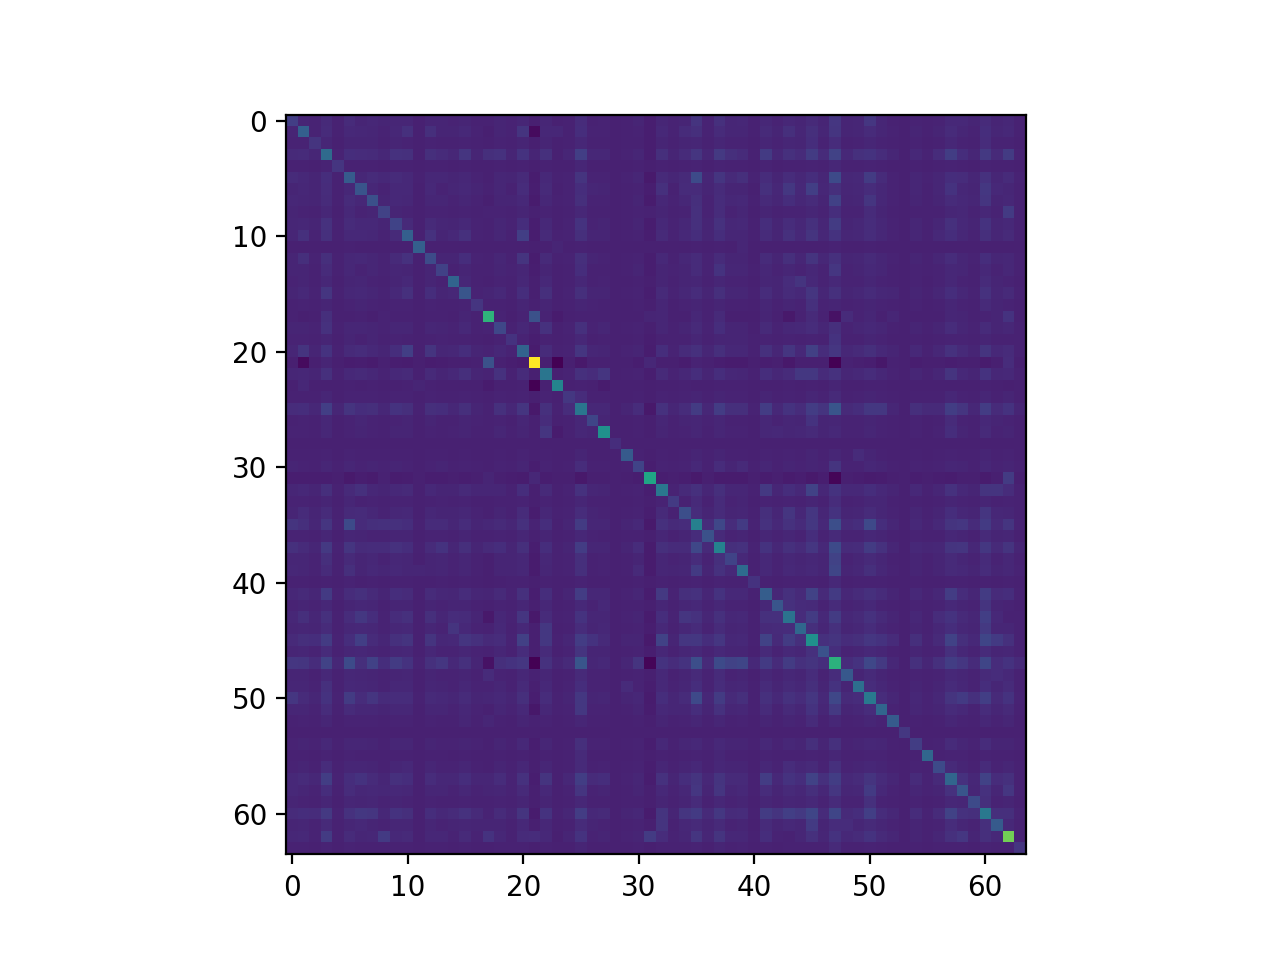

In [27]:
tg_noreg = methods[-4]
tg_noreg[1]['lamb'] = [1.0]
tg_noreg[1]['indexOfPenalty'] = 1
tg_noreg[1]['max_iter'] = 100
tg_noreg[1]['beta'] = [0.0]
tg_noreg_best_score, tg_noreg_best_params, tg_noreg_covs, _ = tg_noreg[0].select(train_data, val_data, tg_noreg[1])
tg_noreg[0].evaluate(test_data)

plt.figure()
plt.imshow(tg_noreg_covs[0])
plt.show()

## GLASSO (from sklearn)

In [28]:
gsk = methods[7]
gsk[1]['alpha'] = [1e-6, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]
gsk_best_score, gsk_best_params, gsk_covs, _ = gsk[0].select(train_data, val_data, gsk[1])
gsk[0].evaluate(test_data)

plt.figure()
plt.imshow(gsk_covs[0])
plt.show()


--------------------------------------------------------------------------------
Selecting the best parameter values for Graphical LASSO (sklearn) ...
done 0 / 7 | running with alpha: 1e-06	
Training Graphical LASSO (sklearn) ...
	Graphical LASSO (sklearn) failed with message: Non SPD result: the system is too ill-conditioned for this solver
	Elapsed time 0.0s
	current score: inf
done 1 / 7 | running with alpha: 0.003	
Training Graphical LASSO (sklearn) ...
	Graphical LASSO (sklearn) failed with message: Non SPD result: the system is too ill-conditioned for this solver
	Elapsed time 0.0s
	current score: inf
done 2 / 7 | running with alpha: 0.01	
Training Graphical LASSO (sklearn) ...
	Graphical LASSO (sklearn) failed with message: Non SPD result: the system is too ill-conditioned for this solver
	Elapsed time 0.0s
	current score: inf
done 3 / 7 | running with alpha: 0.03	
Training Graphical LASSO (sklearn) ...
	Graphical LASSO (sklearn) failed with message: Non SPD result: the system 

/home/harhrayr/miniconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual gap: -6.948e-02
  ConvergenceWarning)
/home/harhrayr/miniconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual gap: 4.863e-03
  ConvergenceWarning)
/home/harhrayr/miniconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual gap: -2.543e-03
  ConvergenceWarning)
/home/harhrayr/miniconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual gap: 1.279e-02
  ConvergenceWarning)
/home/harhrayr/miniconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual 

	Graphical LASSO (sklearn) failed with message: Non SPD result: the system is too ill-conditioned for this solver
	Elapsed time 4.4s
	current score: inf
done 5 / 7 | running with alpha: 0.3	
Training Graphical LASSO (sklearn) ...


/home/harhrayr/miniconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual gap: 7.542e-03
  ConvergenceWarning)
/home/harhrayr/miniconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual gap: 8.666e-04
  ConvergenceWarning)
/home/harhrayr/miniconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual gap: -2.436e-04
  ConvergenceWarning)
/home/harhrayr/miniconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual gap: 1.607e-03
  ConvergenceWarning)
/home/harhrayr/miniconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual g

	Graphical LASSO (sklearn) failed with message: Non SPD result: the system is too ill-conditioned for this solver
	Elapsed time 2.5s
	current score: inf
done 6 / 7 | running with alpha: 1.0	
Training Graphical LASSO (sklearn) ...
	Graphical LASSO (sklearn) failed with message: Non SPD result: the system is too ill-conditioned for this solver
	Elapsed time 0.6s
	current score: inf

Finished with best validation score: inf
Evaluating Graphical LASSO (sklearn) ...
	Score: inf


/home/harhrayr/miniconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual gap: 1.871e-03
  ConvergenceWarning)


<IPython.core.display.Javascript object>

TypeError: 'NoneType' object has no attribute '__getitem__'

# T-CorEx

In [ ]:
tcorex = methods[-1]
tcorex_best_score, tcorex_best_params, tcorex_covs, _ = tcorex[0].select(train_data, val_data, tcorex[1])
tcorex[0].evaluate(test_data)

plt.figure()
plt.imshow(tcorex_covs[0])
plt.show()